In [97]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
!pip install pandas-profiling[notebook,html]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df =pd.read_json('/content/drive/My Drive/Colab Notebooks/reddit_jokes.json')

In [106]:
df.head()

,joke,score
0,I hate how you cant even say black paint anymo...,1
1,"Brian raises his hand and says, “He’s in Heave...",1
2,I walked into a PETA adoption center and the r...,1
3,Remember when you were a kid and when you crie...,15
4,"My boss said to me, ""you're the worst train dr...",3


In [ ]:
df = df[df.score > 0].reset_index()

In [7]:
df.shape

(132992, 5)

In [ ]:
df['joke'] = df['title'] +'. '+ df['body']

In [ ]:
df = df.loc[:,['joke','score']]

In [ ]:
profile = ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [ ]:
profile

Number of variables,2
Number of observations,132992
Total Missing (%),0.0%
Total size in memory,2.0 MiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [32]:
df.score.describe()

count    132992.000000
mean        172.947914
std        1128.187118
min           1.000000
25%           3.000000
50%           8.000000
75%          36.000000
max       48526.000000
Name: score, dtype: float64

It seems that the minimum score we can have is 1 and the maximum is 48526 but since the 75% is far from this value it seems like an outlier



In [43]:
df.score.quantile(0.99)

3932.2699999999895

(-2433.3250791290893, 3932.2699999999895)

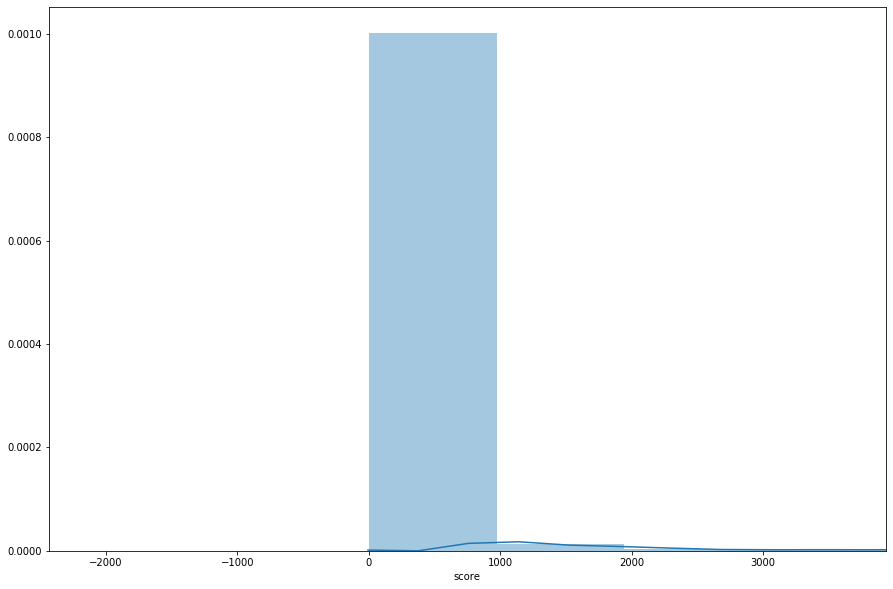

In [48]:
plt.figure(figsize=(15,10))
ax = sns.distplot(df.score)
ax.set_xlim(right=df.score.quantile(0.99))

In [46]:
df.score.quantile(0.86)

101.0

We can see that we have 86% of our score comprised between 1 and 101 and up to around 4000 for 99% 

mean 282.46 std 590.79  max 39744.00


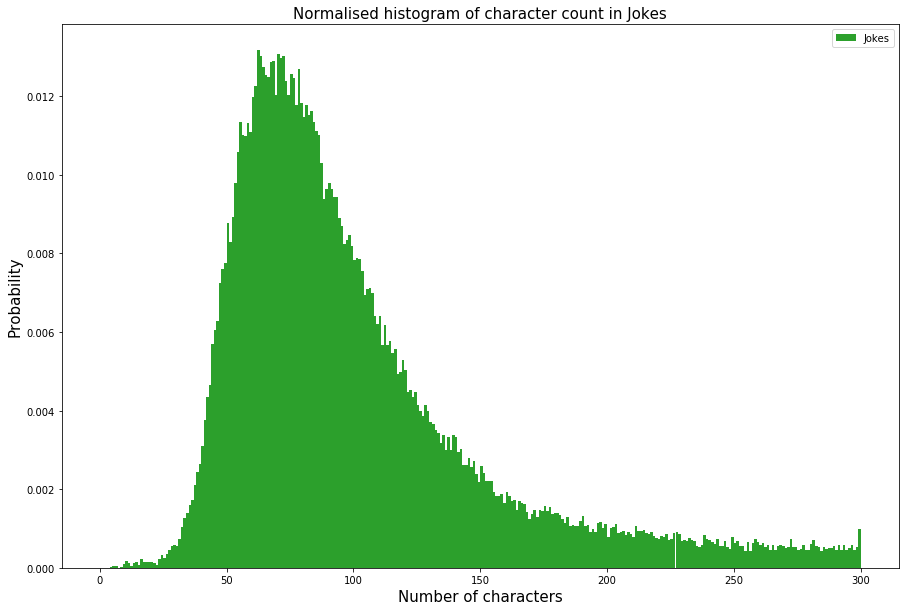

In [112]:
pal = sns.color_palette()
plt.figure(figsize=(15, 10))
plt.hist(df.joke.apply(len), bins=300, range=[0, 300], color=pal[2], density=True, label='Jokes')
plt.title('Normalised histogram of character count in Jokes', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean {:.2f} std {:.2f}  max {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max()))
plt.show()

(-0.5, 1439.5, 1079.5, -0.5)

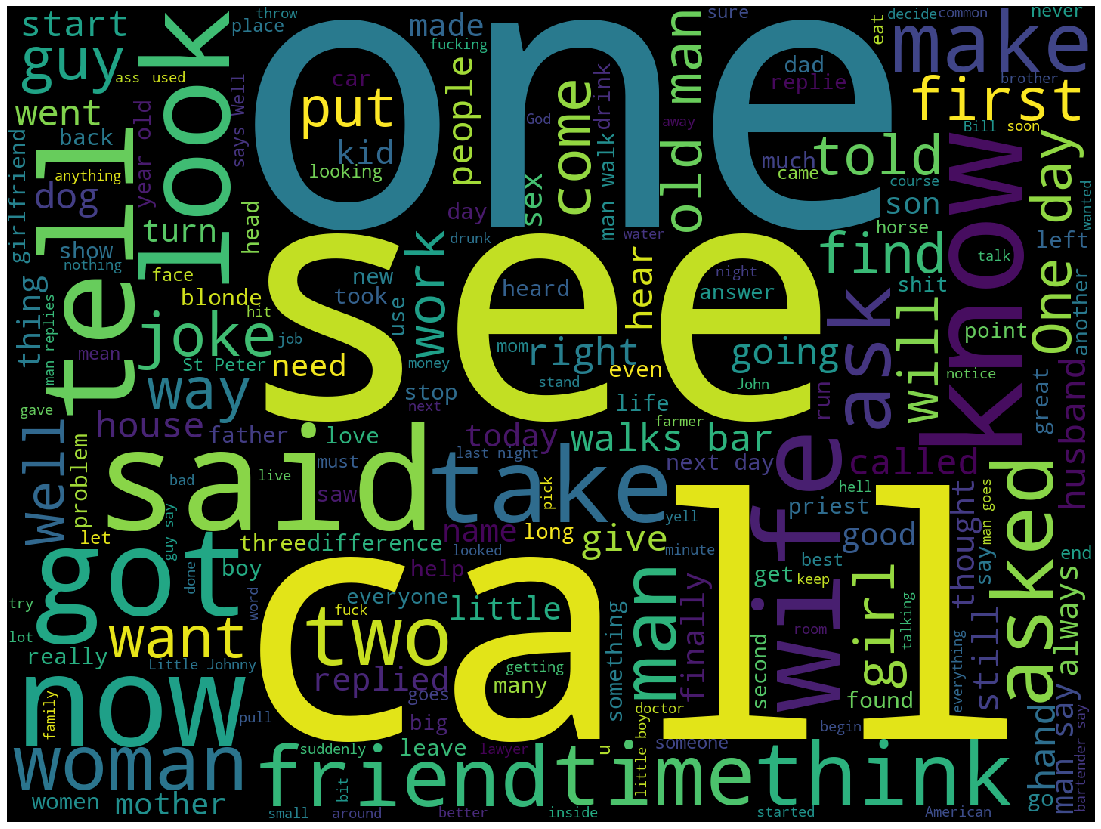

In [26]:
# All words 
cloud = WordCloud(width=1440, height=1080).generate(" ".join(df.joke.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
funniest_jokes = df[df.score >df.score.quantile(0.8)].joke

(-0.5, 1439.5, 1079.5, -0.5)

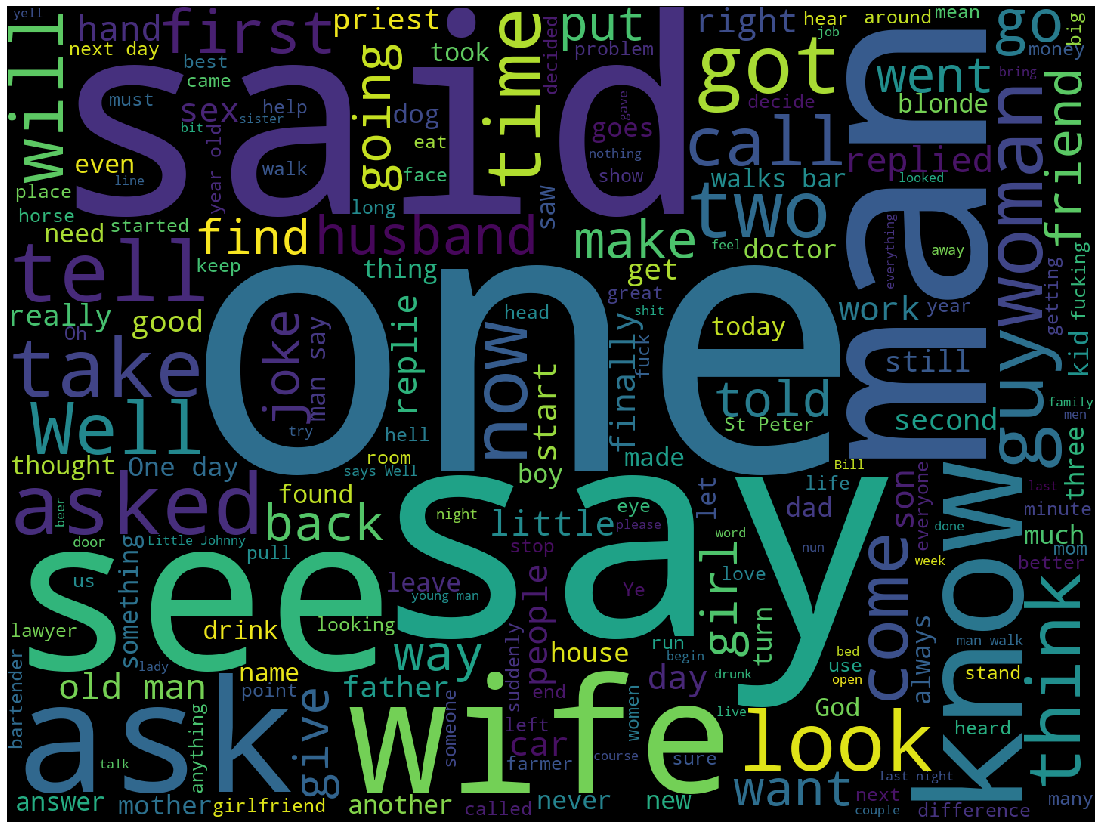

In [110]:
# Funniest Jokes like the top 20% of jokes
cloud = WordCloud(width=1440, height=1080).generate(" ".join(funniest_jokes.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex """
    return len(re.findall(regexp, text))


def numerical_features(df):
    df['char_count'] = df.joke.apply(len)
    df['num_words'] = df.joke.apply(lambda comment: len(comment.split()))
    df['capitals'] = df.joke.apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['char_count']),
    axis=1)
    df['num_exclamation_marks'] = df.joke.apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df.joke.apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df.joke.apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df["num_stopwords"] = df.joke.apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
    df['num_symbols'] = df.joke.apply(
    lambda comment: sum(comment.count(w) for w in '* &$%'))
    df['mean_word_len'] = df.joke.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['num_unique_words'] = df.joke.apply(
    lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df.joke.apply(
    lambda comment: sum(comment.count(w) for w in (': -)', ':)', '; -)', '; )')))
    # Count number of \n
    df["ant_slash_n"]=df.joke.apply(lambda x: count_regexp_occ(r"\n", x))
    # Check for time stamp
    df["has_timestamp"] = df.joke.apply(lambda x: count_regexp_occ(r"\d{2} | : \d{2}", x))
    # Check for http links
    df["has_http"]=df.joke.apply(lambda x: count_regexp_occ(r"http[s]{0, 1}: //\S +", x))
    return df

In [ ]:
df_stats = numerical_features(df.copy())

In [99]:
df_stats.head().T

,0,1,2,3,4
joke,I hate how you cant even say black paint anymo...,"Brian raises his hand and says, “He’s in Heave...",I walked into a PETA adoption center and the r...,Remember when you were a kid and when you crie...,"My boss said to me, ""you're the worst train dr..."
score,1,1,1,15,3
char_count,107,579,162,212,145
num_words,22,101,28,41,28
capitals,4,25,8,3,4
caps_vs_length,0.0373832,0.0431779,0.0493827,0.0141509,0.0275862
num_exclamation_marks,0,1,0,0,0
num_question_marks,1,2,0,1,1
num_punctuation,4,20,5,8,14
num_stopwords,10,37,13,20,11


In [ ]:
def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

In [ ]:
for df_stats in ([df_stats]):
  df_stats['nouns'], df_stats['adjectives'], df_stats['verbs'] = zip(*df_stats.joke.apply(
  lambda comment: tag_part_of_speech(comment)))
  df_stats['nouns_vs_length'] = df_stats['nouns'] / df_stats['char_count']
  df_stats['adjectives_vs_length'] = df_stats['adjectives'] / df_stats['char_count']
  df_stats['verbs_vs_length'] = df_stats['verbs'] /df_stats['char_count']
  df_stats['nouns_vs_words'] = df_stats['nouns'] / df_stats['num_words']
  df_stats['adjectives_vs_words'] = df_stats['adjectives'] / df_stats['num_words']
  df_stats['verbs_vs_words'] = df_stats['verbs'] / df_stats['num_words']
  df_stats["count_words_title"] = df_stats.joke.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
  df_stats['punct_percent']= df_stats['num_punctuation']*100/df_stats['num_words']

In [101]:
df_stats.head().T

,0,1,2,3,4
joke,I hate how you cant even say black paint anymo...,"Brian raises his hand and says, “He’s in Heave...",I walked into a PETA adoption center and the r...,Remember when you were a kid and when you crie...,"My boss said to me, ""you're the worst train dr..."
score,1,1,1,15,3
char_count,107,579,162,212,145
num_words,22,101,28,41,28
capitals,4,25,8,3,4
caps_vs_length,0.0373832,0.0431779,0.0493827,0.0141509,0.0275862
num_exclamation_marks,0,1,0,0,0
num_question_marks,1,2,0,1,1
num_punctuation,4,20,5,8,14
num_stopwords,10,37,13,20,11


Text(0.5, 1, 'Correlation Matrix for Text and NLP Features')

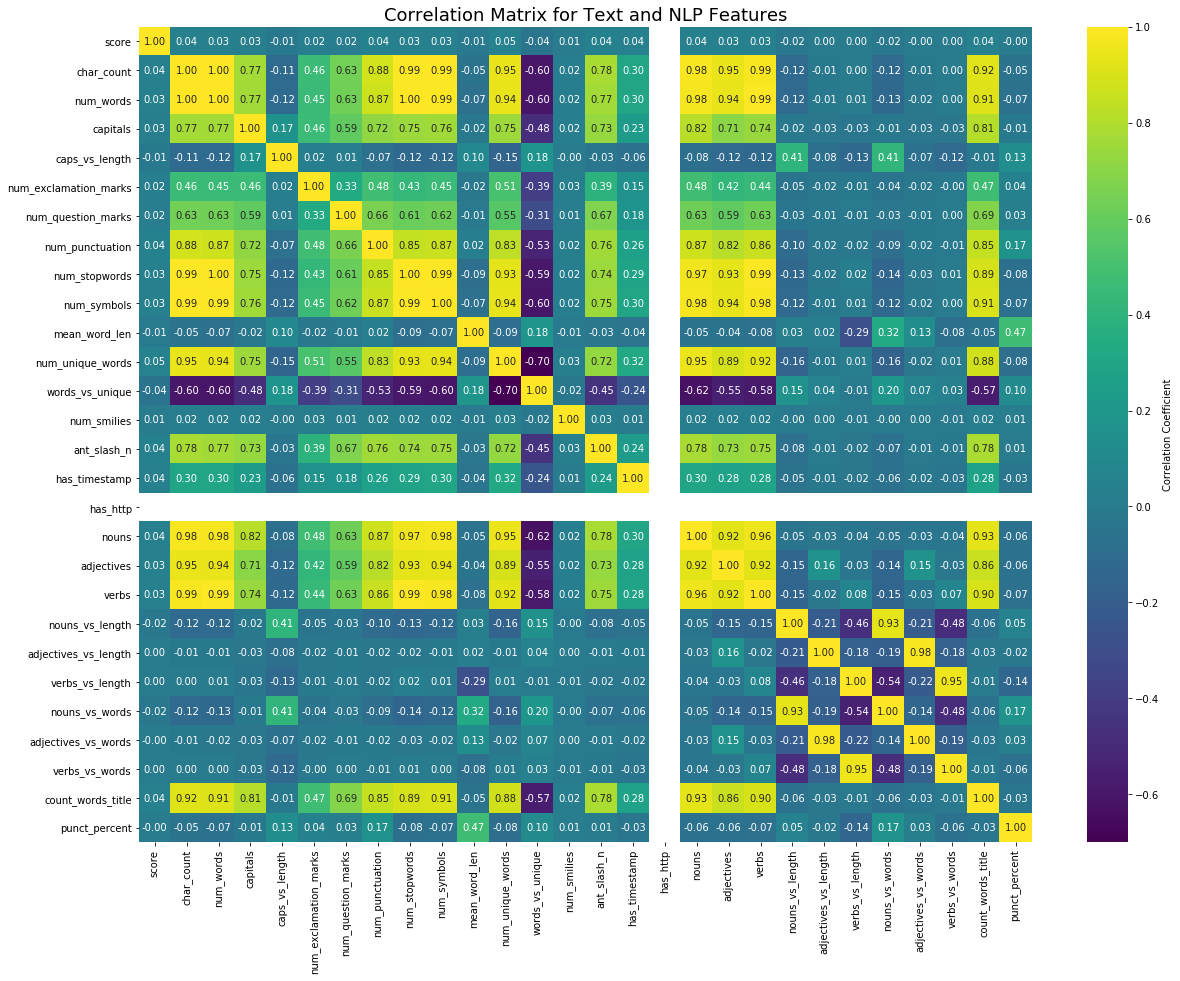

In [103]:
f, ax = plt.subplots(figsize= [20,15])

sns.heatmap(df_stats.drop('joke', axis=1).corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')


ax.set_title("Correlation Matrix for Text and NLP Features", fontsize=18)

In [ ]:
df.to_pickle('/content/drive/My Drive/Colab Notebooks/eda_reddit_jokes.pkl')